In [2]:
import os
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import speech_rate
from scipy.stats.stats import pearsonr
from collections import defaultdict

In [99]:
# Creates a dict of phoneme proportions in words of specific lengths (as no of phonemes) - w_dur in msec.
# Looks like: {"a" : {1pho_w : [w_dur1, pho_prop1, w_dur2, pho_prop2, ...], 2pho_w : [...], ...}, 
#              "b" : {1pho_w : [w_dur1, pho_prop1, w_dur2, pho_prop2, ...], 2pho_w: [...], ...}, 
#               ...}
def build_simple_dict():
    simple_phoprop_dict = defaultdict(dict) # the dict to be returned
    simple_prop_dict = defaultdict(list)   # the value dict
    os.chdir("C:/Users/alexutza_a/Abschlussarbeit/DB_Verbmobil/Evaluation/Training")
    
    #Iterate over the training files
    for datei in glob.glob("*.par"):
        work_file = open(datei)
        for line in work_file:
            if re.match("MAU", line):
                w_dur, phon_count, syl_count = speech_rate.word_duration(datei, int(line.split()[3]))
                key = str(phon_count)+"pho_w"
                simple_prop_dict[key].append(round(w_dur*0.0625, 2))                 # w_dur used in msec.
                simple_prop_dict[key].append(round(int(line.split()[2])/w_dur, 3))   # calc pho prop as pho_dur/w_dur
                if key in simple_phoprop_dict[line.split()[4]].keys():
                    simple_phoprop_dict[line.split()[4]][key] += simple_prop_dict[key]
                else: 
                    simple_phoprop_dict[line.split()[4]][key] = simple_prop_dict[key]
                simple_prop_dict.clear()
        work_file.close()
    return simple_phoprop_dict

In [180]:
# Creates a dict of phoneme durations in words of specific lengths (as no of phonemes) - durations in msec.
# Looks like: {"a" : {1pho_w : [w_dur1, pho_dur1, w_dur2, pho_dur2, ...], 2pho_w : [...], ...}, 
#              "b" : {1pho_w : [w_dur1, pho_dur1, w_dur2, pho_dur2, ...], 2pho_w: [...], ...}, 
#               ...}
def build_simple_durDict():
    simple_ddict = defaultdict(dict) # the dict to be returned
    simple_prop_dict = defaultdict(list)   # the value dict
    os.chdir("C:/Users/alexutza_a/Abschlussarbeit/DB_Verbmobil/Evaluation/Training")
    
    #Iterate over the training files
    for datei in glob.glob("*.par"):
        work_file = open(datei)
        for line in work_file:
            if re.match("MAU", line):
                w_dur, phon_count, syl_count = speech_rate.word_duration(datei, int(line.split()[3]))
                key = str(phon_count)+"pho_w"
                simple_prop_dict[key].append(round(w_dur*0.0625, 3))                 # w_dur used in msec.
                simple_prop_dict[key].append(round(int(line.split()[2])*0.0625, 3))   # pho duration in msec.
                if key in simple_ddict[line.split()[4]].keys():
                    simple_ddict[line.split()[4]][key] += simple_prop_dict[key]
                else: 
                    simple_ddict[line.split()[4]][key] = simple_prop_dict[key]
                simple_prop_dict.clear()
        work_file.close()
    return simple_ddict

In [100]:
# Example call of the simple phoneme proportions dict
%time print(build_simple_dict()["OY"])

{'3pho_w': [189.81, 0.579, 209.81, 0.476, 249.81, 0.48, 209.81, 0.429], '15pho_w': [859.06, 0.116], '5pho_w': [279.69, 0.322], '8pho_w': [789.5, 0.241, 509.5, 0.275, 559.5, 0.196]}


In [96]:
# Help function for getting name and duration of other long pho in word (vowels & nasals & /x/ & /s/)
corr_phonemes = ["a", "a~", "e", "E", "I", "i", "O", "o", "U", "u", "Y", "y", "9", "2", "a:", "a~:", "e:", "E:", "i:",
                 "o:", "u:", "y:", "2:", "OY", "aU", "aI", "@", "6", "m", "n", "N", "x", "s"]
def get_longP(datei, word_no, zeile):
    work_file = open(datei)
    long_Plist = []
    z = 0
    for line in work_file:
        if re.match("MAU", line) and word_no == int(line.split()[3]):
            if (line.split()[4] in corr_phonemes) and (z != zeile):
                w_dur, phon_count, syl_count = speech_rate.word_duration(datei, int(line.split()[3]))
                print("z: " + str(z))
                print("zeile: " + str(zeile))
                long_Plist.append(line.split()[4])
                long_Plist.append(round(int(line.split()[2])/w_dur, 3))
            elif z == zeile:
                continue
        z += 1
    work_file.close()
    return long_Plist

In [84]:
# Creates a dict of phoneme proportions in words of specific lengths (as no of phonemes) - w_dur in msec.
# It considers also the presence of other correlating phonemes in word
# Looks like: {"a" : {1pho_w : [w_dur1, pho_dur1, 0, [], w_dur2, pho_dur2, ...], 
#                     2pho_w : [w_dur1, pho_dur1, no._other_long_pho, [otherPho1, prop_otherPho1, ...], w_dur2, pho_dur2, [...], ...}, 
#              "b" : {1pho_w : [w_dur1, pho_dur1, 0, [], w_dur2, pho_dur2, ...], 2pho_w: [...], ...}, 
#               ...}
def build_complex_dict():
    simple_phoprop_dict = defaultdict(dict) # the dict to be returned
    simple_prop_dict = defaultdict(list)   # the value dict
    
    os.chdir("C:/Users/alexutza_a/Abschlussarbeit/DB_Verbmobil/Evaluation/Training")
    
    #Iterate over the training files
    for datei in glob.glob("*.par"):
        work_file = open(datei)
        zeile = 0                              # a row counter; counting starts at beginning of file
        for line in work_file:
            if re.match("MAU", line):
                w_dur, phon_count, syl_count = speech_rate.word_duration(datei, int(line.split()[3]))
                key = str(phon_count)+"pho_w"
                simple_prop_dict[key].append(str(datei)[-20:])
                simple_prop_dict[key].append(int(line.split()[3]))
                simple_prop_dict[key].append(str(line.split()[4]))
                simple_prop_dict[key].append(round(w_dur*0.0625, 2))                 # w_dur used in msec.
                simple_prop_dict[key].append(round(int(line.split()[2])/w_dur, 3))   # calc pho prop as pho_dur/w_dur
                simple_prop_dict[key].append(get_longP(datei, int(line.split()[3]), zeile))
                if key in simple_phoprop_dict[line.split()[4]].keys():
                    simple_phoprop_dict[line.split()[4]][key] += simple_prop_dict[key]
                else: 
                    simple_phoprop_dict[line.split()[4]][key] = simple_prop_dict[key]
                simple_prop_dict.clear()
            zeile += 1
        work_file.close()
    return simple_phoprop_dict

In [97]:
# Example call of the complex phoneme proportions dict
%time print(build_complex_dict()["OY"])

{'3pho_w': ['g001acn1_027_AAJ.par', 0, 'OY', 189.81, 0.579, ['n', 0.21], 'g001acn1_029_AAJ.par', 4, 'OY', 209.81, 0.476, ['n', 0.143], 'g001acn2_026_AAK.par', 5, 'OY', 249.81, 0.48, ['n', 0.32], 'g001acn2_028_AAK.par', 0, 'OY', 209.81, 0.429, ['n', 0.381]], '15pho_w': ['g001acn1_071_AAJ.par', 23, 'OY', 859.06, 0.116, ['n', 0.046]], '5pho_w': ['g001acn2_007_AAK.par', 59, 'OY', 279.69, 0.322, ['n', 0.214]], '8pho_w': ['g016acn1_010_ABE.par', 20, 'OY', 789.5, 0.241, ['u:', 0.177, 's', 0.089], 'g016acn1_016_ABE.par', 40, 'OY', 509.5, 0.275, ['u:', 0.098, 's', 0.157], 'g016acn2_015_ABO.par', 3, 'OY', 559.5, 0.196, ['u:', 0.161, 's', 0.107]]}
Wall time: 11.2 s


In [101]:
# Build the simple phoneme proportions dictionary
%time simple_pprop_dict = build_simple_dict()

Wall time: 3.61 s


In [102]:
# Bild the complex phoneme proportions dictionary
%time complex_pprop_dict = build_complex_dict()

Wall time: 10.7 s


In [181]:
# Build the simple phoneme durations dictionary against word-length (key)
%time simple_ddict = build_simple_durDict()

Wall time: 3.59 s


In [183]:
from operator import itemgetter

# sort needed dict_list from the simple (!) dict
def sort_dict_val(dict_value_list):
#    dict_value_list = simple_pprop_dict["a:"]["2pho_w"]
    l_gr = [dict_value_list[i:i+2] for i in range(0, len(dict_value_list),2)] # transform list in list of 2-elem-lists
    l_sorted = sorted(l_gr,key=itemgetter(0)) # sort list of of 2-elem-lists
    org_simpleDict_val = []
    for i in range(len(l_sorted)):    # flatten sorted list
        org_simpleDict_val += l_sorted[i]
    return org_simpleDict_val
#print(sort_dict_val(simple_pprop_dict["a:"]["2pho_w"])[:14])

[69.88, 0.572, 69.88, 0.572, 69.88, 0.572, 79.88, 0.625, 79.88, 0.5, 79.88, 0.625, 79.88, 0.625]


In [193]:
# Test data for plot /a:/-durations in 2pho_w against w_dur
simple_wdur_list = sort_dict_val(simple_ddict["a:"]["2pho_w"])[::2]
#simple_wdur_list = [ round(x/1000, 3) for x in simple_wdur_list]     #transform w_dur in sec (from msec)
simple_pdur_list = sort_dict_val(simple_ddict["a:"]["2pho_w"])[1::2]
print(len(simple_pdur_list))
print(simple_pdur_list[:5])
print(simple_wdur_list[:5])

100
[39.938, 39.938, 39.938, 49.938, 39.938]
[69.88, 69.88, 69.88, 79.88, 79.88]


In [187]:
# Test data for plot /a:/-proportions in 2pho_w against w_dur
simple_dur_list = sort_dict_val(simple_pprop_dict["a:"]["2pho_w"])[::2]
simple_dur_list = [ round(x/1000, 3) for x in simple_dur_list]     #transform w_dur in sec (from msec)
simple_prop_list = sort_dict_val(simple_pprop_dict["a:"]["2pho_w"])[1::2]
print(len(simple_dur_list))

100


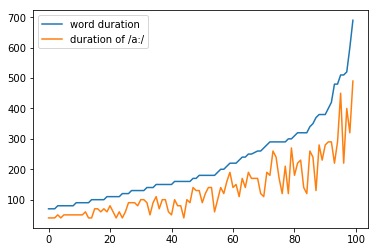

In [194]:
# This Graph shows that the duration of /a:/ in 2-phoneme-words correlates very well with word duration
x = range(100)
plt.plot(x, simple_wdur_list, label = "word duration")
plt.plot(x, simple_pdur_list, label = "duration of /a:/")
plt.legend()
plt.show()

0.915711745557


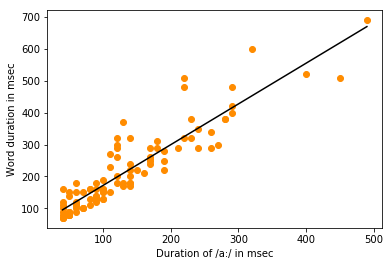

In [196]:
# This scatter plot confirms the result of the previous plot
print(pearsonr(simple_pdur_list, simple_wdur_list)[0])
m, b = np.polyfit(simple_pdur_list, simple_wdur_list,1) # elem. of the regression function
plt.scatter(simple_pdur_list, simple_wdur_list, color = "darkorange")
plt.plot((np.unique(simple_pdur_list)), (m*(np.unique(simple_pdur_list)) + b), "-", color="k") # plot regression line
plt.xlabel("Duration of /a:/ in msec")
plt.ylabel("Word duration in msec")
plt.show()

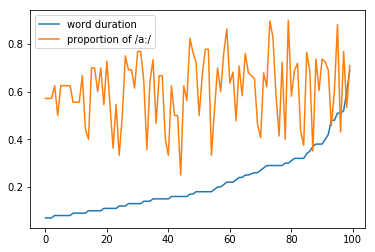

In [120]:
# This Graph shows that the proportion of /a:/ in 2-phoneme-words doesn't correlate with word duration
x = range(100)
plt.plot(x, simple_dur_list, label = "word duration (s)")
plt.plot(x, simple_prop_list, label = "proportion of /a:/")
plt.legend()
plt.show()

(0.13910368379366647, 0.1675039412470333)


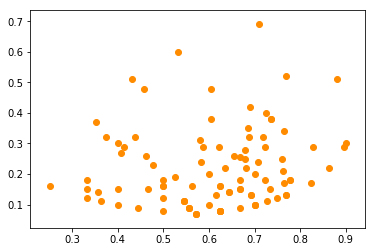

In [152]:
# This scatter plot confirms the result of the previous plot
print(pearsonr(simple_prop_list, simple_dur_list))
plt.scatter(simple_prop_list, simple_dur_list, color = "darkorange")
plt.show()

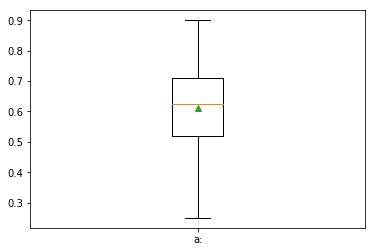

Median: 0.625
Mean: 0.61112
Q1: 0.5195   Q3: 0.7085


In [160]:
# Would suggest it makes sense to use only the interquartile area, or even just the mean/median value
plt.boxplot(simple_prop_list, labels = ["a:"], showmeans=True)
plt.show()
print("Median: " + str(np.median(simple_prop_list)))
print("Mean: " + str(np.mean(simple_prop_list)))
Q1 = np.percentile(simple_prop_list, 25)
Q3 = np.percentile(simple_prop_list, 75)
print("Q1: " + str(Q1) + "   Q3: " + str(Q3))

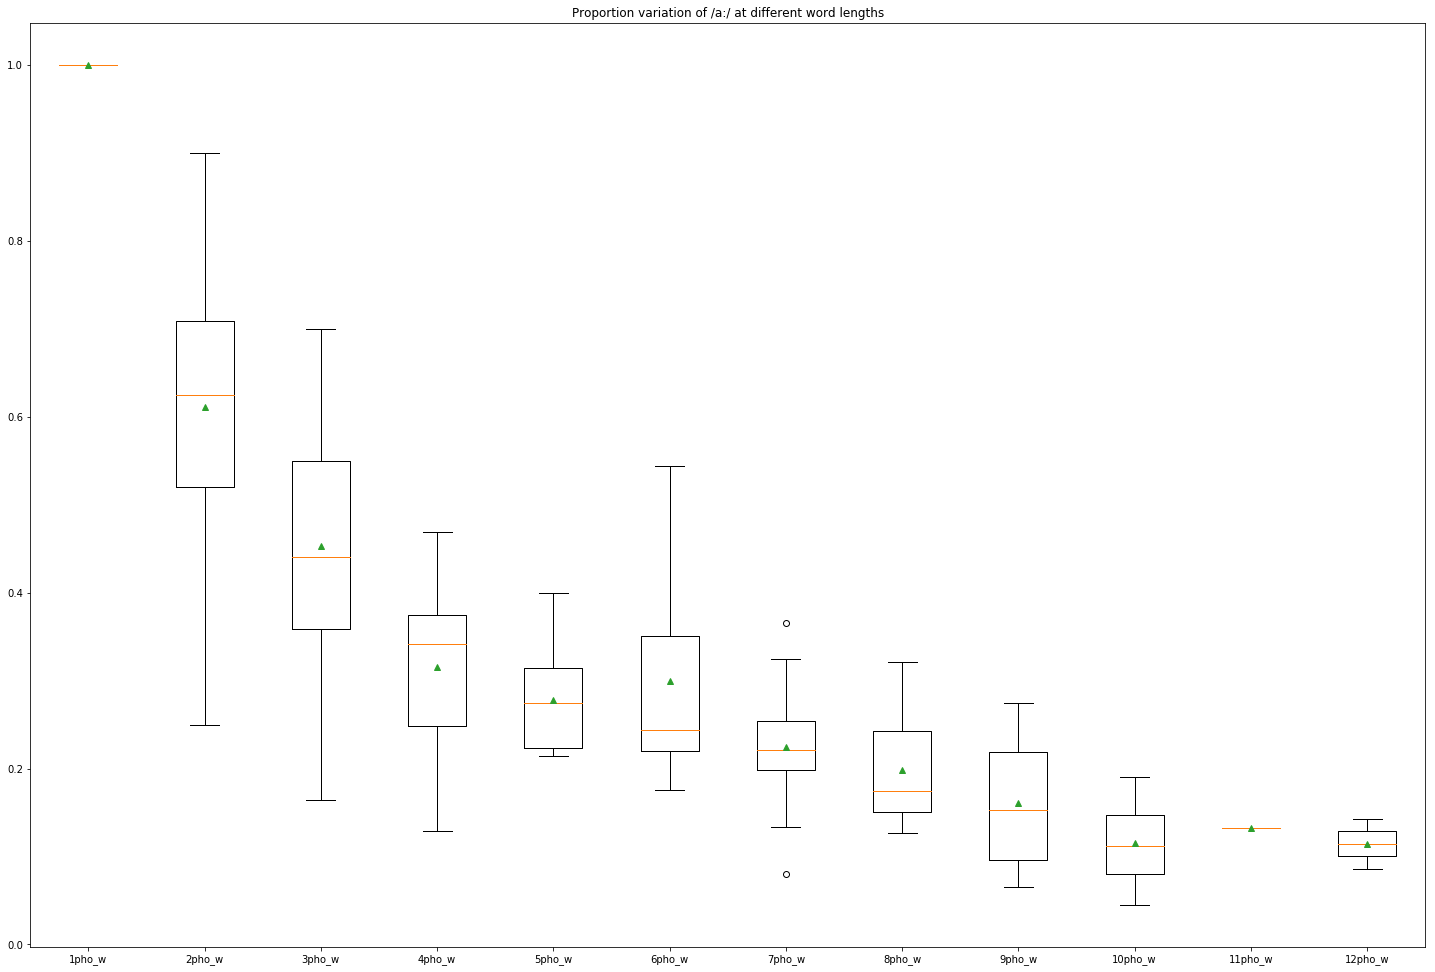

[1, 100, 49, 12, 10, 11, 19, 24, 4, 4, 1, 2]
1pho_w:
  Median: 1.0 Mean: 1.0 Q1: 1.0   Q3: 1.0
2pho_w:
  Median: 0.625 Mean: 0.611 Q1: 0.52   Q3: 0.708
3pho_w:
  Median: 0.44 Mean: 0.453 Q1: 0.359   Q3: 0.55
4pho_w:
  Median: 0.342 Mean: 0.315 Q1: 0.248   Q3: 0.374
5pho_w:
  Median: 0.274 Mean: 0.278 Q1: 0.223   Q3: 0.314
6pho_w:
  Median: 0.244 Mean: 0.3 Q1: 0.22   Q3: 0.351
7pho_w:
  Median: 0.221 Mean: 0.225 Q1: 0.198   Q3: 0.254
8pho_w:
  Median: 0.174 Mean: 0.198 Q1: 0.15   Q3: 0.243
9pho_w:
  Median: 0.153 Mean: 0.161 Q1: 0.096   Q3: 0.219
10pho_w:
  Median: 0.112 Mean: 0.115 Q1: 0.08   Q3: 0.147
11pho_w:
  Median: 0.132 Mean: 0.132 Q1: 0.132   Q3: 0.132
12pho_w:
  Median: 0.114 Mean: 0.114 Q1: 0.1   Q3: 0.129


In [199]:
# This plot confirms the intuition, that the percent occupied by /a:/ decreases with length of word (as # of phonemes)
# Boxplot with /a:/-proportions overview on all word legths
prop_lists = []

# sort data by increasing word length
key_list = sorted(simple_pprop_dict["a:"].keys())
first_3 = key_list[:3]
key_list = key_list[3:] + first_3

# generate list of lists for plotting
for el in key_list:
    prop_lists.append(simple_pprop_dict["a:"][el][1::2])

# create a list of count/word-length
count_list = []
for el in prop_lists:
    count_list.append(len(el))

# actually plot data
plt.figure(figsize=(25, 17))
plt.boxplot(prop_lists, labels = key_list, showmeans=True)
plt.title("Proportion variation of /a:/ at different word lengths")
plt.show()
print(count_list)
# print some boxplot relevant info (median, mean, Q1, Q3)
for el in prop_lists:   
    print(key_list[prop_lists.index(el)] + ":")
    Q1 = np.percentile(el, 25)
    Q3 = np.percentile(el, 75)
    print("  Median: " + str(round(np.median(el), 3)) + " Mean: " + str(round(np.mean(el), 3)) + 
          " Q1: " + str(round(Q1, 3)) + "   Q3: " + str(round(Q3, 3)))
   

In [200]:
# Test data for plot /a:/-durations in 3pho_w against w_dur
simple_w3dur_list = sort_dict_val(simple_ddict["a:"]["3pho_w"])[::2]
#simple_wdur_list = [ round(x/1000, 3) for x in simple_wdur_list]     #transform w_dur in sec (from msec)
simple_p3dur_list = sort_dict_val(simple_ddict["a:"]["3pho_w"])[1::2]
#print(len(simple_p3dur_list))
print(simple_pdur_list[:5])
print(simple_wdur_list[:5])

[39.938, 39.938, 39.938, 49.938, 39.938]
[69.88, 69.88, 69.88, 79.88, 79.88]


0.779046924945


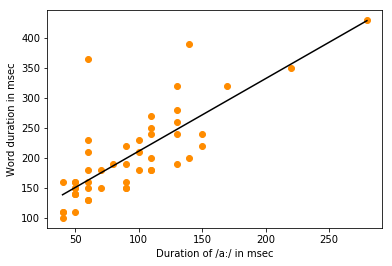

In [201]:
# This scatter plot confirms the result of the previous plot
print(pearsonr(simple_p3dur_list, simple_w3dur_list)[0])
m, b = np.polyfit(simple_p3dur_list, simple_w3dur_list,1) # elem. of the regression function
plt.scatter(simple_p3dur_list, simple_w3dur_list, color = "darkorange")
plt.plot((np.unique(simple_p3dur_list)), (m*(np.unique(simple_p3dur_list)) + b), "-", color="k") # plot regression line
plt.xlabel("Duration of /a:/ in msec")
plt.ylabel("Word duration in msec")
plt.show()

In [124]:
from operator import itemgetter
# sort needed dict_list from the complex dict
complex_dict_la2p = complex_pprop_dict["a:"]["2pho_w"]
l_gr = [complex_dict_la2p[i:i+6] for i in range(0, len(complex_dict_la2p),6)] # transform list in list of 2-elem-lists
l_sorted = sorted(l_gr,key=itemgetter(3)) # sort list of of 2-elem-lists
org_complexDict_la2p = []
for i in range(len(l_sorted)):    # flatten sorted list
    org_complexDict_la2p += l_sorted[i]
print(org_complexDict_la2p[:30])

['g001acn1_004_AAJ.par', 8, 'a:', 69.88, 0.572, [], 'g001acn2_016_AAK.par', 0, 'a:', 69.88, 0.572, [], 'g016acn1_029_ABE.par', 0, 'a:', 69.88, 0.572, [], 'g001acn1_000_AAJ.par', 0, 'a:', 79.88, 0.625, [], 'g001acn1_004_AAJ.par', 3, 'a:', 79.88, 0.5, []]


In [136]:
# Split Value list of complex dict for ["a:"]["2pho_w] into word lists with corr phonemes (lw) and without (no_lw)
# The result shows here already, that this approach will not bring us much, as there are only 2 instances, where
#     a correlating phoneme is present in word. 
no_lw, lw = [], []
i = 0
for el in org_complexDict_la2p[5::6]:
    if el == []:
        no_lw.append(org_complexDict_la2p[3::6][i])
        no_lw.append(org_complexDict_la2p[4::6][i])
    else:
        lw.append(org_complexDict_la2p[3::6][i])
        lw.append(org_complexDict_la2p[4::6][i])
    i += 1
print(lw)

[89.88, 0.556, 379.88, 0.605]


100
[0.572, 0.572, 0.572, 0.625, 0.5]
